<a href="https://colab.research.google.com/github/sid2610/HPE_Goal/blob/main/Goalpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
%pip install azure-storage-blob

     |████████████████████████████████| 348kB 5.8MB/s 
     |████████████████████████████████| 92kB 7.2MB/s 
     |████████████████████████████████| 133kB 13.1MB/s 
     |████████████████████████████████| 3.2MB 14.0MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [ ]:
import os, uuid
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

try:
    print("Azure Blob storage v" + __version__ + " - Python quickstart sample")
    # Quick start code goes here
except Exception as ex:
    print('Exception:')
    print(ex)

Azure Blob storage v12.7.1 - Python quickstart sample


In [ ]:
STORAGEACCOUNTNAME= "goalpost"
STORAGEACCOUNTKEY= "XxIo41gxOujT4SI/cxe06qYWY4+Xurdj8ErK6rZ1Masa4UO2fJZw/U9iFQKAoXst1do02hv5ZF7B9dVd4YLOyg=="

In [ ]:
connect_str  = 'DefaultEndpointsProtocol=https;AccountName=goalpost;AccountKey=XxIo41gxOujT4SI/cxe06qYWY4+Xurdj8ErK6rZ1Masa4UO2fJZw/U9iFQKAoXst1do02hv5ZF7B9dVd4YLOyg==;EndpointSuffix=core.windows.net'
!pwd

/content


In [ ]:
CONTAINERNAMES = ["train", "val", "test"]
local_file_name = "_annotations.csv"

In [ ]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [ ]:
for c in CONTAINERNAMES:
    os.mkdir("./" + c)
    blob_client = blob_service_client.get_blob_client(container=c, blob=local_file_name)
    with open("./"+c+"/annots.csv", "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import random

In [ ]:
def extract_frame(frame, x, y, h, w):
    hh = int(h/2)
    ww = int(w/2)
    if x>=ww and x<(frame.shape[1]-ww):
        lx = ww
    elif x<ww:
        lx = x
    else:
        lx = w-(frame.shape[1]-x)
    if y>=hh and y<(frame.shape[0]-hh):
        ly = hh
    elif y<hh:
        ly = y
    else:
        ly = h-(frame.shape[0]-y)
    return frame[y-ly:y+h-ly, x-lx:x+w-lx]

In [ ]:
def sliding_window(img, win, step):
    for y in range(0,img.shape[0]-win[1],step):
        for x in range(0,img.shape[1]-win[0],step):
            yield (x,y,img[y:y+win[1],x:x+win[0]])

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [ ]:
from scipy.ndimage.filters import convolve

In [ ]:
def sobel_edges(img):
    img = rgb2gray(img)
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    return np.hypot(Ix, Iy)

In [ ]:
train = pd.read_csv("./train/annots.csv")
val = pd.read_csv("./val/annots.csv")
test = pd.read_csv("./test/annots.csv")

In [ ]:
train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_8721_PNG.rf.004e79b2445b05c5db0ba82051bc4e...,416,416,goal-post,276,68,343,178
1,IMG_9284_PNG.rf.00b00d7f1ae044f5c5385da8be9e0b...,416,416,goal-post,220,156,313,266
2,IMG_9088_PNG.rf.01909db3d58348af710abb4279f4b8...,416,416,goal-post,238,11,288,69
3,IMG_8587_PNG.rf.01ae09f35dfcf3356c00251e5739dc...,416,416,goal-post,318,71,379,247
4,IMG_8916_PNG.rf.02516219c14c025a7f2c9ecba288bf...,416,416,goal-post,79,143,120,205
...,...,...,...,...,...,...,...,...
667,IMG_8801_PNG.rf.f148a62ad122b2dc8d14bfbae2a2ff...,416,416,goal-post,189,105,269,183
668,IMG_8442_PNG.rf.f15c590c08b005bfa53fdbfe207f04...,416,416,goal-post,233,115,312,226
669,IMG_8924_PNG.rf.f170989845ba01bcb005e45113f4fc...,416,416,goal-post,91,156,146,235
670,IMG_8795_PNG.rf.f1937ac461f1ad98407579df3b3f1d...,416,416,goal-post,127,47,204,146


In [ ]:
train['x'] = (train['xmin'] + train['xmax'])/2
train['x'] = [int(t) for t in train['x']]
val['x'] = (val['xmin'] + val['xmax'])/2
val['x'] = [int(t) for t in val['x']]
test['x'] = (test['xmin'] + test['xmax'])/2
test['x'] = [int(t) for t in test['x']]
train['y'] = (train['ymin'] + train['ymax'])/2
train['y'] = [int(t) for t in train['y']]
val['y'] = (val['ymin'] + val['ymax'])/2
val['y'] = [int(t) for t in val['y']]
test['y'] = (test['ymin'] + test['ymax'])/2
test['y'] = [int(t) for t in test['y']]

In [ ]:
train['w'] = train['xmax'] - train['xmin']
val['w'] = val['xmax'] - val['xmin']
test['w'] = test['xmax'] - test['xmin']
train['h'] = train['ymax'] - train['ymin']
val['h'] = val['ymax'] - val['ymin']
test['h'] = test['ymax'] - test['ymin']

In [ ]:
train['s'] = np.max([train['w'], train['h']], axis=0)
test['s'] = np.max([test['w'], test['h']], axis=0)
val['s'] = np.max([val['w'], val['h']], axis=0)

In [ ]:
train['l'] = [100*(1+int(t/100)) for t in train['s']]
val['l'] = [100*(1+int(t/100)) for t in val['s']]
test['l'] = [100*(1+int(t/100)) for t in test['s']]

In [ ]:
test

,filename,width,height,class,xmin,ymin,xmax,ymax,x,y,w,h,s,l
0,IMG_9089_PNG.rf.00ab560bb364b53c873a80f2547d12...,416,416,goal-post,235,13,288,70,261,41,53,57,57,100
1,IMG_9350_PNG.rf.07e58ed106037c0d405adb22cde008...,416,416,goal-post,240,141,326,253,283,197,86,112,112,200
2,IMG_8672_PNG.rf.04119303312cd6e6fa29f38232352e...,416,416,goal-post,163,134,223,212,193,173,60,78,78,100
3,IMG_8376_PNG.rf.15675f18a5c9fc7fd845aadc0b3f46...,416,416,goal-post,223,111,337,262,280,186,114,151,151,200
4,IMG_8393_PNG.rf.0de070a9786c1bfbc56f8c55aa9595...,416,416,goal-post,131,115,209,311,170,213,78,196,196,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,IMG_8967_PNG.rf.eff978379b8b07ea03c00c1623a557...,416,416,goal-post,111,37,175,136,143,86,64,99,99,100
93,IMG_8548_PNG.rf.f66595b3a7d5d65848ce21689fb56b...,416,416,goal-post,261,113,339,214,300,163,78,101,101,200
94,IMG_9097_PNG.rf.f66b63aa59542391638d637d1a3cff...,416,416,goal-post,45,100,146,215,95,157,101,115,115,200
95,IMG_9090_PNG.rf.ddd6e90aa2f7141c1df21ad3ecd738...,416,416,goal-post,236,12,286,72,261,42,50,60,60,100


In [ ]:
train_img = []
for f in train['filename']:
    c = "train"
    blob_client = blob_service_client.get_blob_client(container=c, blob=f)
    with open("./train/"+f, "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)
    t = plt.imread("./train/"+f)
    train_img.append(t)
len(train_img)

672

In [ ]:
np.max(train['h'])

323

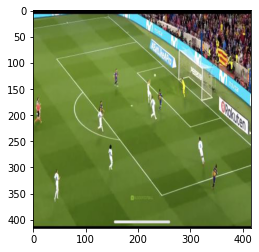

In [ ]:
plt.imshow(train_img[0])

In [ ]:
val_img = []
for f in val['filename']:
    c = "val"
    blob_client = blob_service_client.get_blob_client(container=c, blob=f)
    with open("./val/"+f, "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)
    t = plt.imread("./val/"+f)
    val_img.append(t)
len(val_img)

191

In [ ]:
test_img = []
for f in test['filename']:
    c = "test"
    blob_client = blob_service_client.get_blob_client(container=c, blob=f)
    with open("./test/"+f, "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)
    t = plt.imread("./test/"+f)
    test_img.append(t)
len(test_img)

97

In [ ]:
import cv2

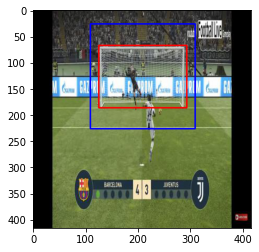

In [ ]:
i = 600
clone = train_img[i].copy()
x = train['x'][i]
y = train['y'][i]
l = int(train['l'][i]/2)
cv2.rectangle(clone, (train['xmin'][i],train['ymin'][i]), (train['xmax'][i],train['ymax'][i]), (255,0,0), 2)
cv2.rectangle(clone, (x-l,y-l), (x+l,y+l), (0,0,255), 2)
plt.imshow(clone)

In [ ]:
len(train)

672

In [ ]:
import pickle

In [ ]:
with open ('/content/drive/MyDrive/Datasets/ISSIA/data/tx', 'rb') as fp:
    tx = pickle.load(fp)
with open ('/content/drive/MyDrive/Datasets/ISSIA/data/ty', 'rb') as fp:
    ty = pickle.load(fp)

In [ ]:
import random
import skimage
from skimage.transform import resize
from skimage.color import rgb2gray

In [ ]:
os.mkdir("./videos")

In [ ]:
os.mkdir("./annots")

In [ ]:
STORAGEACCOUNTNAME= "issia"
STORAGEACCOUNTKEY= "I8mH/fx5qd+6XxC3qF2K9V/pqZZMmEr+FA7p18pZz+QVXJEuRuWLvXQ07aWmd4LdSdAbVgu/qLy0ioS9etnwCg=="
CONTAINERNAME= "videos"

In [ ]:
 connect_str  = 'DefaultEndpointsProtocol=https;AccountName=issia;AccountKey=I8mH/fx5qd+6XxC3qF2K9V/pqZZMmEr+FA7p18pZz+QVXJEuRuWLvXQ07aWmd4LdSdAbVgu/qLy0ioS9etnwCg==;EndpointSuffix=core.windows.net'
!pwd

/content


In [ ]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [ ]:
for i in range(6):
    local_file_name = "Cam-" + str(i+1) + ".mp4"
    blob_client = blob_service_client.get_blob_client(container=CONTAINERNAME, blob=local_file_name)
    t = "./videos/Cam-" + str(i+1) + ".mp4"
    with open(t, "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)

In [ ]:
STORAGEACCOUNTNAME= "issia"
STORAGEACCOUNTKEY= "I8mH/fx5qd+6XxC3qF2K9V/pqZZMmEr+FA7p18pZz+QVXJEuRuWLvXQ07aWmd4LdSdAbVgu/qLy0ioS9etnwCg=="
CONTAINERNAME= "annots"

In [ ]:
connect_str  = 'DefaultEndpointsProtocol=https;AccountName=issia;AccountKey=I8mH/fx5qd+6XxC3qF2K9V/pqZZMmEr+FA7p18pZz+QVXJEuRuWLvXQ07aWmd4LdSdAbVgu/qLy0ioS9etnwCg==;EndpointSuffix=core.windows.net'
!pwd

/content


In [ ]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [ ]:
for i in range(6):
    local_file_name = "Cam-" + str(i+1) + ".csv"
    blob_client = blob_service_client.get_blob_client(container=CONTAINERNAME, blob=local_file_name)
    t = "./annots/Cam-" + str(i+1) + ".csv"
    with open(t, "wb") as my_blob:
        blob_data = blob_client.download_blob()
        blob_data.readinto(my_blob)

In [ ]:
vid = []
for i in range(6):
    t = imageio.get_reader("./videos/Cam-" + str(i+1) + ".mp4")
    vid.append(t)

In [ ]:
vid[0].get_data(0).shape

(1088, 1920, 3)

In [ ]:
gx = []
gy = []

In [ ]:
for i in range(len(train)):
    t = train_img[i]
    x = train['x'][i]
    y = train['y'][i]
    l = train['l'][i]
    t = extract_frame(t, x, y, l, l)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(1)
    f = random.choice(vid)
    j = random.randint(0,2995)
    f = f.get_data(j)
    x = random.randint(0,1919)
    y = random.randint(0,1079)
    t = extract_frame(f, x, y, 500,500)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(0)
    print(len(gx), len(gy))

2 2
4 4
6 6
8 8
10 10
12 12
14 14
16 16
18 18
20 20
22 22
24 24
26 26
28 28
30 30
32 32
34 34
36 36
38 38
40 40
42 42
44 44
46 46
48 48
50 50
52 52
54 54
56 56
58 58
60 60
62 62
64 64
66 66
68 68
70 70
72 72
74 74
76 76
78 78
80 80
82 82
84 84
86 86
88 88
90 90
92 92
94 94
96 96
98 98
100 100
102 102
104 104
106 106
108 108
110 110
112 112
114 114
116 116
118 118
120 120
122 122
124 124
126 126
128 128
130 130
132 132
134 134
136 136
138 138
140 140
142 142
144 144
146 146
148 148
150 150
152 152
154 154
156 156
158 158
160 160
162 162
164 164
166 166
168 168
170 170
172 172
174 174
176 176
178 178
180 180
182 182
184 184
186 186
188 188
190 190
192 192
194 194
196 196
198 198
200 200
202 202
204 204
206 206
208 208
210 210
212 212
214 214
216 216
218 218
220 220
222 222
224 224
226 226
228 228
230 230
232 232
234 234
236 236
238 238
240 240
242 242
244 244
246 246
248 248
250 250
252 252
254 254
256 256
258 258
260 260
262 262
264 264
266 266
268 268
270 270
272 272
274 274
276 276
27

In [ ]:
for i in range(len(val)):
    t = val_img[i]
    x = val['x'][i]
    y = val['y'][i]
    l = val['l'][i]
    t = extract_frame(t, x, y, l, l)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(1)
    f = random.choice(vid)
    j = random.randint(0,2995)
    f = f.get_data(j)
    x = random.randint(0,1919)
    y = random.randint(0,1079)
    t = extract_frame(f, x, y, 500,500)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(0)
    print(len(gx), len(gy))

1346 1346
1348 1348
1350 1350
1352 1352
1354 1354
1356 1356
1358 1358
1360 1360
1362 1362
1364 1364
1366 1366
1368 1368
1370 1370
1372 1372
1374 1374
1376 1376
1378 1378
1380 1380
1382 1382
1384 1384
1386 1386
1388 1388
1390 1390
1392 1392
1394 1394
1396 1396
1398 1398
1400 1400
1402 1402
1404 1404
1406 1406
1408 1408
1410 1410
1412 1412
1414 1414
1416 1416
1418 1418
1420 1420
1422 1422
1424 1424
1426 1426
1428 1428
1430 1430
1432 1432
1434 1434
1436 1436
1438 1438
1440 1440
1442 1442
1444 1444
1446 1446
1448 1448
1450 1450
1452 1452
1454 1454
1456 1456
1458 1458
1460 1460
1462 1462
1464 1464
1466 1466
1468 1468
1470 1470
1472 1472
1474 1474
1476 1476
1478 1478
1480 1480
1482 1482
1484 1484
1486 1486
1488 1488
1490 1490
1492 1492
1494 1494
1496 1496
1498 1498
1500 1500
1502 1502
1504 1504
1506 1506
1508 1508
1510 1510
1512 1512
1514 1514
1516 1516
1518 1518
1520 1520
1522 1522
1524 1524
1526 1526
1528 1528
1530 1530
1532 1532
1534 1534
1536 1536
1538 1538
1540 1540
1542 1542
1544 1544


In [ ]:
for i in range(len(test)):
    t = test_img[i]
    x = test['x'][i]
    y = test['y'][i]
    l = test['l'][i]
    t = extract_frame(t, x, y, l, l)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(1)
    f = random.choice(vid)
    j = random.randint(0,2995)
    f = f.get_data(j)
    x = random.randint(0,1919)
    y = random.randint(0,1079)
    t = extract_frame(f, x, y, 500,500)
    t = resize(t, (100,100))
    gx.append(rgb2gray(t))
    gy.append(0)
    print(len(gx), len(gy))

1728 1728
1730 1730
1732 1732
1734 1734
1736 1736
1738 1738
1740 1740
1742 1742
1744 1744
1746 1746
1748 1748
1750 1750
1752 1752
1754 1754
1756 1756
1758 1758
1760 1760
1762 1762
1764 1764
1766 1766
1768 1768
1770 1770
1772 1772
1774 1774
1776 1776
1778 1778
1780 1780
1782 1782
1784 1784
1786 1786
1788 1788
1790 1790
1792 1792
1794 1794
1796 1796
1798 1798
1800 1800
1802 1802
1804 1804
1806 1806
1808 1808
1810 1810
1812 1812
1814 1814
1816 1816
1818 1818
1820 1820
1822 1822
1824 1824
1826 1826
1828 1828
1830 1830
1832 1832
1834 1834
1836 1836
1838 1838
1840 1840
1842 1842
1844 1844
1846 1846
1848 1848
1850 1850
1852 1852
1854 1854
1856 1856
1858 1858
1860 1860
1862 1862
1864 1864
1866 1866
1868 1868
1870 1870
1872 1872
1874 1874
1876 1876
1878 1878
1880 1880
1882 1882
1884 1884
1886 1886
1888 1888
1890 1890
1892 1892
1894 1894
1896 1896
1898 1898
1900 1900
1902 1902
1904 1904
1906 1906
1908 1908
1910 1910
1912 1912
1914 1914
1916 1916
1918 1918
1920 1920


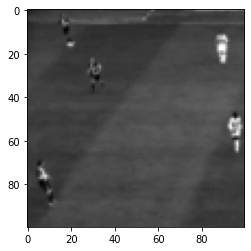

In [ ]:
plt.imshow(gx[17], 'gray')

In [ ]:
with open('/content/drive/MyDrive/Datasets/ISSIA/data/gx', 'wb') as fp:
    pickle.dump(gx,fp)
with open('/content/drive/MyDrive/Datasets/ISSIA/data/gy', 'wb') as fp:
    pickle.dump(gy,fp)

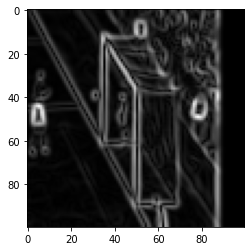

In [ ]:
plt.imshow(sobel_edges(test), 'gray')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
goal_cnn = Sequential()

In [ ]:
goal_cnn.add(Conv2D(16, (5,5), (1,1), 'same', activation='relu', input_shape = (100,100,1)))
goal_cnn.add(BatchNormalization(-1))
goal_cnn.add(MaxPooling2D((2,2)))
goal_cnn.add(Dropout(0.25))

goal_cnn.add(Conv2D(32, (2,2), (1,1), 'same', activation='relu'))
goal_cnn.add(BatchNormalization(-1))
goal_cnn.add(MaxPooling2D((2,2)))
goal_cnn.add(Dropout(0.25))

goal_cnn.add(Flatten())
goal_cnn.add(Dense(1024, activation='relu'))
goal_cnn.add(Dense(64, activation='relu'))
goal_cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
goal_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
goalx = np.expand_dims(np.asarray(gx), 3)
goaly = np.expand_dims(np.asarray(gy), 1)

In [ ]:
(x_train, x_val, y_train, y_val) = train_test_split(goalx, goaly, test_size=0.5, shuffle=True)

In [ ]:
x_train.shape

(960, 100, 100, 1)

In [ ]:
np.sum(y_val)

472

In [ ]:
goal_cnn.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

Train on 960 samples, validate on 960 samples
Epoch 1/10
960/960 [==============================] - 22s 23ms/sample - loss: 0.3299 - acc: 0.9740 - val_loss: 0.7922 - val_acc: 0.8000
Epoch 2/10
960/960 [==============================] - 21s 22ms/sample - loss: 0.1483 - acc: 0.9948 - val_loss: 7.9605 - val_acc: 0.5125
Epoch 3/10
960/960 [==============================] - 21s 22ms/sample - loss: 0.0133 - acc: 0.9979 - val_loss: 20.1081 - val_acc: 0.5031
Epoch 4/10
960/960 [==============================] - 21s 22ms/sample - loss: 2.0896e-04 - acc: 1.0000 - val_loss: 28.7444 - val_acc: 0.5031
Epoch 5/10
960/960 [==============================] - 21s 22ms/sample - loss: 1.6290e-06 - acc: 1.0000 - val_loss: 33.7979 - val_acc: 0.5031
Epoch 6/10
 96/960 [==>...........................] - ETA: 15s - loss: 3.9907e-15 - acc: 1.0000

KeyboardInterrupt: ignored

In [ ]:
for i in range(5):
    goal_cnn.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=1)
    goal_cnn.fit(x_val, y_val, validation_data=(x_train, y_train), batch_size=32, epochs=1)

Train on 960 samples, validate on 960 samples
960/960 [==============================] - 22s 23ms/sample - loss: 0.1295 - acc: 0.9823 - val_loss: 0.1220 - val_acc: 0.9615
Train on 960 samples, validate on 960 samples
960/960 [==============================] - 21s 22ms/sample - loss: 0.5388 - acc: 0.9896 - val_loss: 2.9104 - val_acc: 0.6729
Train on 960 samples, validate on 960 samples
960/960 [==============================] - 21s 22ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 15.5447 - val_acc: 0.5135
Train on 960 samples, validate on 960 samples
960/960 [==============================] - 21s 22ms/sample - loss: 0.1366 - acc: 0.9969 - val_loss: 34.4623 - val_acc: 0.4917
Train on 960 samples, validate on 960 samples
960/960 [==============================] - 21s 22ms/sample - loss: 0.0065 - acc: 0.9990 - val_loss: 52.6768 - val_acc: 0.5083
Train on 960 samples, validate on 960 samples
960/960 [==============================] - 21s 22ms/sample - loss: 0.2969 - acc: 0.9969 - va